# Librerias

In [107]:
#%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import os
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import tree

# Tratando datos
## El unico
Como esta dataset esta separado en varias carpeta lo que he decidido es por cada categoria crear un unico fichero donde se agrupe todo los datos de esta categoria

In [108]:
all_files_idle = glob.glob("data/idle/*.csv")
all_files_running = glob.glob("data/running/*.csv")
all_files_stairs = glob.glob("data/stairs/*.csv")
all_files_walking = glob.glob("data/walking/*.csv")

df_from_each_file_idle = (pd.read_csv(f) for f in all_files_idle)
df_from_each_file_running = (pd.read_csv(f) for f in all_files_running)
df_from_each_file_stairs = (pd.read_csv(f) for f in all_files_stairs)
df_from_each_file_walking = (pd.read_csv(f) for f in all_files_walking)

df_idle = pd.concat(df_from_each_file_idle, axis=0, ignore_index=True)
df_idle = df_idle.assign(action=0)

df_running = pd.concat(df_from_each_file_running, axis=0, ignore_index=True)
df_running = df_running.assign(action=1)

df_stairs = pd.concat(df_from_each_file_stairs, axis=0, ignore_index=True)
df_stairs = df_stairs.assign(action=2)

df_walking = pd.concat(df_from_each_file_walking, axis=0, ignore_index=True)
df_walking = df_walking.assign(action=3)

Generamos nuestro dataset (los 4 ficheros convertidos a 1) y printamos los 5 primeros elementos

In [109]:
df = pd.concat([df_idle, df_running, df_stairs, df_walking], axis=0, ignore_index=True)
df.head()

,accelerometer_X,accelerometer_Y,accelerometer_Z,action
0,1.000776,4.616021,8.576031,0
1,0.718261,4.209007,8.446744,0
2,-0.909797,-0.282516,9.203311,0
3,5.099650,0.148441,8.418014,0
4,1.762132,-0.162806,9.251195,0


## Entender los datos
Miramos que no tengamos nulos antes de todo

In [110]:
df.isnull().sum()

accelerometer_X    0
accelerometer_Y    0
accelerometer_Z    0
action             0
dtype: int64

<AxesSubplot:>

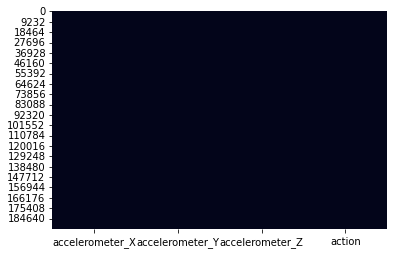

In [111]:
sns.heatmap(df.isnull(), cbar=False)

Mostramos descripcion de cada una para asi saber en que valores se encutran

In [112]:
print("IDLE", df_idle.describe(),"\n")
print("RUNNING",df_running.describe(),"\n")
print("STAIRS", df_stairs.describe(),"\n")
print("WALKING",df_walking.describe(),"\n")
print("DATASET", df.describe(),"\n")

IDLE        accelerometer_X  accelerometer_Y  accelerometer_Z   action
count     31170.000000     31170.000000     31170.000000  31170.0
mean          0.096767         2.225971         8.973247      0.0
std           0.691892         2.821235         1.211058      0.0
min         -10.448297        -2.595315        -0.296881      0.0
25%          -0.110133        -0.028730         8.116344      0.0
50%           0.234632         0.028730         9.749189      0.0
75%           0.277727         5.310340         9.773131      0.0
max           8.135497         9.916783        21.988348      0.0 

RUNNING        accelerometer_X  accelerometer_Y  accelerometer_Z    action
count    102240.000000    102240.000000    102240.000000  102240.0
mean          5.045705         8.083135         1.387356       1.0
std           9.952696        12.441402         7.004236       0.0
min         -39.188293       -39.188293       -39.188293       1.0
25%          -1.532289        -0.742202        -2.873042

Informacion de los datos

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193860 entries, 0 to 193859
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   accelerometer_X  193860 non-null  float64
 1   accelerometer_Y  193860 non-null  float64
 2   accelerometer_Z  193860 non-null  float64
 3   action           193860 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 5.9 MB


Podemos observar que en nuestro dataset no tenemos las misma cantidas de muestras para cada categoria, esto podria ser un problema para el entrenamiento de nuestro modelo. 

In [114]:
activity_labels = ['idle', 'running', 'stairs', 'walking']
for activity in activity_labels:
    file_names_list = os.listdir(os.path.join('data', activity))
    print(activity, ': ', len(file_names_list))

idle :  1039
running :  3408
stairs :  165
walking :  1850


Creamos las funciones necesarias para poder mostrar una grafica de nuestros datos

In [115]:
def plot_3d_trajectory(x, y, z, title):
    x = cumtrapz(x)
    y = cumtrapz(y)
    z = cumtrapz(z)
    
    fig3,ax = plt.subplots()
    fig3.suptitle(title,fontsize=20)
    ax = plt.axes(projection='3d')
    ax.plot3D(x,y,z,c='red',lw=1,label='phone trajectory')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_zlabel('Z position')
    plt.show()

def select_actributs(avtivity):
    x = avtivity.accelerometer_X.values
    y = avtivity.accelerometer_Y.values
    z = avtivity.accelerometer_Z.values
    return x, y, z
    
def select_random_df(folder_name):
    custom_path = os.path.join('data/', folder_name)
    data = pd.read_csv(os.path.join(custom_path, os.listdir(custom_path)[0]))
    x = data.accelerometer_X.values
    y = data.accelerometer_Y.values
    z = data.accelerometer_Z.values
    return x, y, z

mostramos la distribucion de los datos de la union de todos los caminos

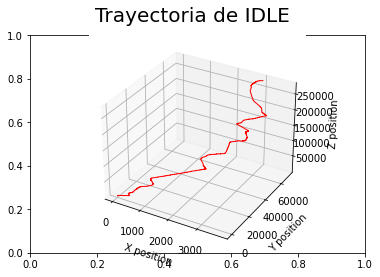

In [116]:
# Idle
x,y,z = select_actributs(df_idle)
plot_3d_trajectory(x, y, z, 'Trayectoria de IDLE')

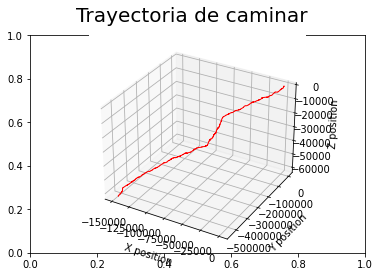

In [117]:
# Walking
x,y,z = select_actributs(df_walking)
plot_3d_trajectory(x, y, z, 'Trayectoria de caminar')

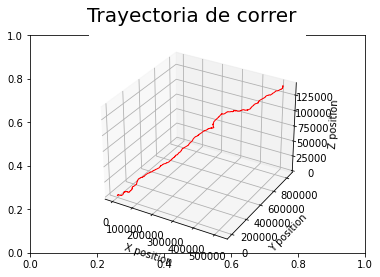

In [118]:
# running
x,y,z = select_actributs(df_running)
plot_3d_trajectory(x, y, z, 'Trayectoria de correr')

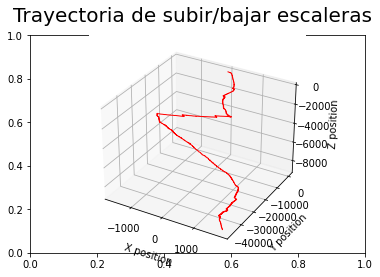

In [119]:
# stairs
x,y,z = select_actributs(df_stairs)
plot_3d_trajectory(x, y, z, 'Trayectoria de subir/bajar escaleras')

mostramos la distribucion de los datos de un unico camino

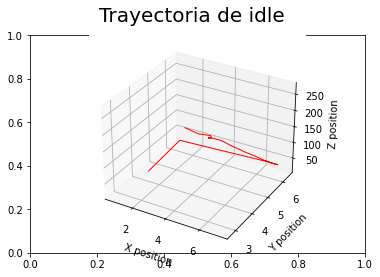

In [120]:
# idle
x,y,z = select_random_df('idle')
plot_3d_trajectory(x, y, z, 'Trayectoria de idle')

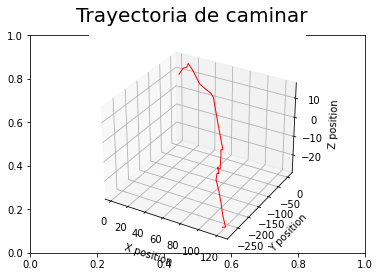

In [121]:
# Walking
x,y,z = select_random_df('walking')
plot_3d_trajectory(x, y, z, 'Trayectoria de caminar')

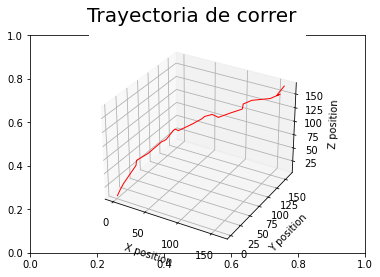

In [122]:
# running
x,y,z = select_random_df('running')
plot_3d_trajectory(x, y, z, 'Trayectoria de correr')

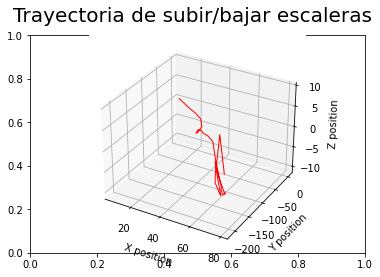

In [123]:
# stairs
x,y,z = select_random_df('stairs')
plot_3d_trajectory(x, y, z, 'Trayectoria de subir/bajar escaleras')

Matriz de relacion entre las variables

<AxesSubplot:>

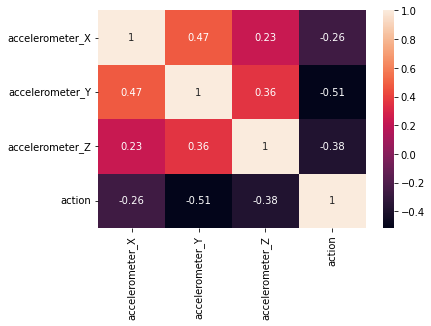

In [124]:
sns.heatmap(df.corr(), annot=True)

## Union de trayectorias

Como podemos observar, nuestro dataset esta compuesto por muchos ficheros de cada categoria, pero seria un error entrenar con este dataset ya que no estamos teniendo en cuenta las trayectorias, solo los puntos, para solucionar esto tranformaremos nuestro dataset en un dataset de medisa por cada fichero (trayectoria)

In [125]:
def mean_calculator(trayectoria):
    trayectoria_ejes = np.array(trayectoria)
    x = trayectoria_ejes[:, 0]
    y = trayectoria_ejes[:, 1]
    z = trayectoria_ejes[:, 2]
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    z_mean = np.mean(x)
    return x_mean, y_mean, z_mean

In [126]:
def feature_engineer(action, target, df):
    x_mean, y_mean, z_mean = mean_calculator(action)
    dictionary = {
        'x_mean': x_mean,
        'y_mean': y_mean, 
        'z_mean': z_mean,
        'target': target
    }
    df = df.append(dictionary, ignore_index=True)
    return df

In [127]:
columns = ['x_mean', 'y_mean', 'z_mean', 'target']
dataframe = pd.DataFrame(columns=columns)

for activity in activity_labels:
    activity_files = os.listdir(os.path.join('data', activity))
    for file in activity_files:
        df = pd.read_csv(os.path.join('data', activity, file))
        array = df.to_numpy()
        dataframe = feature_engineer(array, activity, dataframe)

In [128]:
print(dataframe.shape)
dataframe.head()

(6462, 4)


,x_mean,y_mean,z_mean,target
0,0.178448,0.167435,0.178448,idle
1,-0.098641,-0.131202,-0.098641,idle
2,-0.099918,0.220905,-0.099918,idle
3,0.400949,-0.029528,0.400949,idle
4,0.400949,-0.027134,0.400949,idle


# Creacion del Modelo

## Antes de todo
Vamos a dividir nuestro dataset en entreno y test, personalmente me gusta la distribucion de 80% entreno y el 20% restante para el test

In [129]:
X = dataframe[['x_mean', 'y_mean', 'z_mean']]
Y = dataframe['target']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Como en nuestros datos estan mal valanceados vamos a incrementar los daots con SMOTE para a la hora de poder entrenar nuestro modelo exista mas variedad entre estos.

In [130]:
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

## Clasificador

### SVM: rbf

Entrenamos nuestro modelo

In [131]:
svm_model = svm.SVC()
svm_model.fit(X_train, y_train)

SVC()

Vamos ha ver que tal efectivo es

In [132]:
print("Efectividad del entreno:", svm_model.score(X_train, y_train))
print("Efectividad del test: ", svm_model.score(X_test, y_test))
print(f'F1-Sore: ', f1_score(y_test, svm_model.predict(X_test), average='macro'))

Efectividad del entreno: 0.8962853990437661
Efectividad del test:  0.925754060324826
F1-Sore:  0.8019011559945007


Vamos ha hecharle un vistazo a nuestra matriz de confusion, podemos observar que para las clases 0,1 y 3 tenemos muy buena clasificacion, pero sin embargo para la clase 2 ha fallado bastante, esto se debe a que nuestro datos estan desvalanzeados en el sentido que de la clase 2 (stairs) no tiene muchas muestras, por lo que no se puede clasificar con una buena precision.

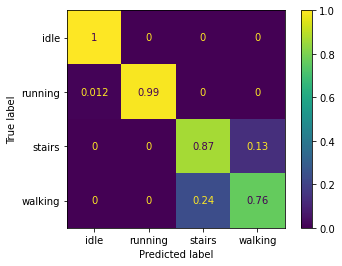

In [133]:
ConfusionMatrixDisplay.from_estimator(svm_model, X_test, y_test, normalize='true')

### SVM: linear

In [134]:
svm_model_linear = svm.SVC(kernel='linear')
svm_model_linear.fit(X_train, y_train)

SVC(kernel='linear')

In [135]:
print("Efectividad del entreno:", svm_model_linear.score(X_train, y_train))
print("Efectividad del test: ", svm_model_linear.score(X_test, y_test))
print(f'F1-Sore: ', f1_score(y_test, svm_model_linear.predict(X_test), average='macro'))

Efectividad del entreno: 0.8700809121000368
Efectividad del test:  0.9002320185614849
F1-Sore:  0.7720730063998377


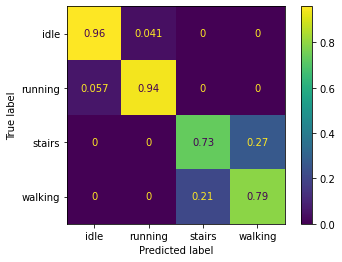

In [136]:
ConfusionMatrixDisplay.from_estimator(svm_model_linear, X_test, y_test, normalize='true')

### SVM: poly


In [137]:
svm_model_poly = svm.SVC(kernel='poly')
svm_model_poly.fit(X_train, y_train)

SVC(kernel='poly')

In [138]:
print("Efectividad del entreno:", svm_model_poly.score(X_train, y_train))
print("Efectividad del test: ", svm_model_poly.score(X_test, y_test))
print(f'F1-Sore: ', f1_score(y_test, svm_model_poly.predict(X_test), average='macro'))

Efectividad del entreno: 0.892515630746598
Efectividad del test:  0.922660479505027
F1-Sore:  0.7964451832130002


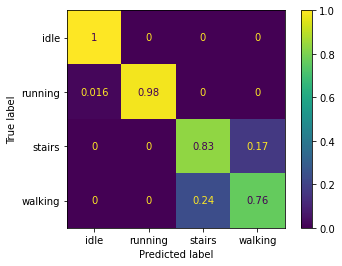

In [139]:
ConfusionMatrixDisplay.from_estimator(svm_model_poly, X_test, y_test, normalize='true')

### SVM: sigmoid

In [140]:
svm_model_sigmoid = svm.SVC(kernel='sigmoid')
svm_model_sigmoid.fit(X_train, y_train)

SVC(kernel='sigmoid')

In [141]:
print("Efectividad del entreno:", svm_model_sigmoid.score(X_train, y_train))
print("Efectividad del test: ", svm_model_sigmoid.score(X_test, y_test))
print(f'F1-Sore: ', f1_score(y_test, svm_model_sigmoid.predict(X_test), average='macro'))

Efectividad del entreno: 0.6680764987127621
Efectividad del test:  0.7037896365042536
F1-Sore:  0.5936966950962503


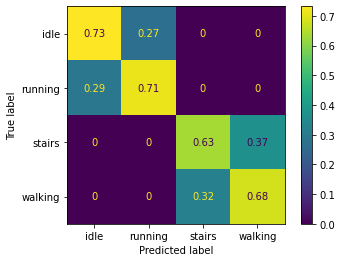

In [142]:
ConfusionMatrixDisplay.from_estimator(svm_model_sigmoid, X_test, y_test, normalize='true')

Con todos los distintos kernels de SVM no es posible obtener un buen resultado para todas las clases y a mas el tiempo de entreo es demasiado alto para las muestras que tenemos, asi que vamos a probar otro modelo para ver si este nos puede resolver el problema que tenemos.

### Decision Tree

entrenamos nuestro model

In [143]:
decision_tree_model = tree.DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [144]:
print("Efectividad del entreno:", decision_tree_model.score(X_train, y_train))
print("Efectividad del test: ", decision_tree_model.score(X_test, y_test))
print(f'F1-Sore: ', f1_score(y_test, decision_tree_model.predict(X_test), average='macro'))

Efectividad del entreno: 1.0
Efectividad del test:  0.9520494972931168
F1-Sore:  0.8166757452240749


observamos la matriz de confusion

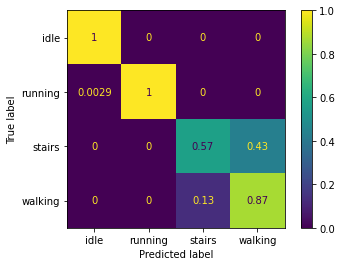

In [145]:
ConfusionMatrixDisplay.from_estimator(decision_tree_model, X_test, y_test, normalize='true')

observamos el arbol de decision

[Text(236.06805115628615, 213.41333333333333, 'X[1] <= -3.463\ngini = 0.75\nsamples = 10876\nvalue = [2719, 2719, 2719, 2719]'),
 Text(141.59613701471227, 205.36, 'X[0] <= -1.117\ngini = 0.5\nsamples = 5438\nvalue = [0, 0, 2719, 2719]'),
 Text(50.48277273713129, 197.30666666666667, 'X[0] <= -4.192\ngini = 0.261\nsamples = 2347\nvalue = [0, 0, 363, 1984]'),
 Text(48.159117445054946, 189.25333333333333, 'X[0] <= -4.199\ngini = 0.003\nsamples = 592\nvalue = [0, 0, 1, 591]'),
 Text(47.3845656810295, 181.2, 'gini = 0.0\nsamples = 582\nvalue = [0, 0, 0, 582]'),
 Text(48.93366920908039, 181.2, 'X[2] <= -4.199\ngini = 0.18\nsamples = 10\nvalue = [0, 0, 1, 9]'),
 Text(48.159117445054946, 173.14666666666668, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1, 0]'),
 Text(49.70822097310584, 173.14666666666668, 'gini = 0.0\nsamples = 9\nvalue = [0, 0, 0, 9]'),
 Text(52.80642802920764, 189.25333333333333, 'X[2] <= -2.907\ngini = 0.327\nsamples = 1755\nvalue = [0, 0, 362, 1393]'),
 Text(52.031876265182184, 

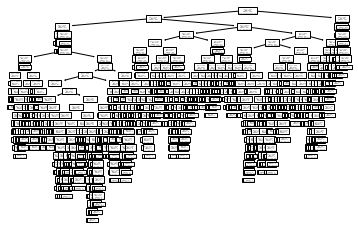

In [146]:
tree.plot_tree(decision_tree_model)

### Random forest

In [147]:
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)

RandomForestClassifier()

In [148]:
print("Efectividad del entreno:", random_forest_model.score(X_train, y_train))
print("Efectividad del test: ", random_forest_model.score(X_test, y_test))
print(f'F1-Sore: ', f1_score(y_test, random_forest_model.predict(X_test), average='macro'))

Efectividad del entreno: 1.0
Efectividad del test:  0.951276102088167
F1-Sore:  0.8119343189712712


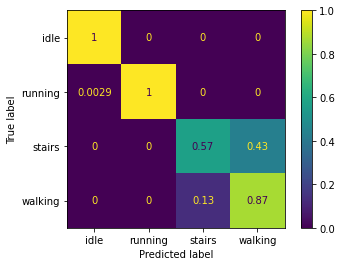

In [149]:
ConfusionMatrixDisplay.from_estimator(decision_tree_model, X_test, y_test, normalize='true')

## Validacion de modelos

In [150]:
modelos = pd.DataFrame(columns=["modelo","mean", "std"])

### SVM: rbf

In [151]:
cross_val_svm = cross_val_score(svm_model, X_test, y_test, cv=10, scoring='f1_macro')
mean = cross_val_svm.mean()
std = cross_val_svm.std()
print("Efectividad del entreno:", mean)
print("Desviacion estandar:", std)
modelos = modelos.append({'modelo': 'SVM_rbf', 'mean': mean, 'std': std}, ignore_index=True)

Efectividad del entreno: 0.7354448473929354
Desviacion estandar: 0.0057858257266888


## SVM: linear

In [152]:
cross_val_svm_linear = cross_val_score(svm_model_linear, X_test, y_test, cv=10, scoring='f1_macro')
mean = cross_val_svm_linear.mean()
std = cross_val_svm_linear.std()
print("Efectividad del entreno:", mean)
print("Desviacion estandar:", std)
modelos = modelos.append({'modelo': 'SVM_linear', 'mean': mean, 'std': std}, ignore_index=True)

Efectividad del entreno: 0.7134973498914802
Desviacion estandar: 0.014077648362464565


### SVM: poly

In [153]:
cross_val_svm_poly = cross_val_score(svm_model_poly, X_test, y_test, cv=10, scoring='f1_macro')
mean = cross_val_svm_poly.mean()
std = cross_val_svm_poly.std()
print("Efectividad del entreno:", mean)
print("Desviacion estandar:", std)
modelos = modelos.append({'modelo': 'SVM_poly', 'mean': mean, 'std': std}, ignore_index=True)

Efectividad del entreno: 0.732587954537363
Desviacion estandar: 0.008340848262466312


### SVM: sigmoide

In [154]:
cross_val_svm_sigmoid = cross_val_score(svm_model_sigmoid, X_test, y_test, cv=10, scoring='f1_macro')
mean = cross_val_svm_sigmoid.mean()
std = cross_val_svm_sigmoid.std()
print("Efectividad del entreno:", mean)
print("Desviacion estandar:", std)
modelos = modelos.append({'modelo': 'SVM_sigmoide', 'mean': mean, 'std': std}, ignore_index=True)

Efectividad del entreno: 0.5943998488599865
Desviacion estandar: 0.01977024971168307


### Decision Tree

In [155]:
cross_val_decision_tree = cross_val_score(decision_tree_model, X_test, y_test, cv=10, scoring='f1_macro')
mean = cross_val_decision_tree.mean()
std = cross_val_decision_tree.std()
print("Efectividad del entreno:", mean)
print("Desviacion estandar:", std)
modelos = modelos.append({'modelo': 'Decision tree', 'mean': mean, 'std': std}, ignore_index=True)

Efectividad del entreno: 0.8536680591555758
Desviacion estandar: 0.028625959517264106


### Random forest

In [156]:
cross_val_random_forest = cross_val_score(random_forest_model, X_test, y_test, cv=10, scoring='f1_macro')
mean = cross_val_random_forest.mean()
std = cross_val_random_forest.std()
print("Efectividad del entreno:", mean)
print("Desviacion estandar:", std)
modelos = modelos.append({'modelo': 'Random Forest', 'mean': mean, 'std': std}, ignore_index=True)

Efectividad del entreno: 0.8241467519603864
Desviacion estandar: 0.063009288569257


## Comparativas de modelos

Tras la realizacion del cross validation vamos a mostrar los resultados ordenados por score para poder tener de una forma mas clara que modelo es mejor para nuestro problema

In [157]:
modelos.sort_values(by="mean", ascending=False)

,modelo,mean,std
4,Decision tree,0.853668,0.028626
5,Random Forest,0.824147,0.063009
0,SVM_rbf,0.735445,0.005786
2,SVM_poly,0.732588,0.008341
1,SVM_linear,0.713497,0.014078
3,SVM_sigmoide,0.594400,0.019770


## Conclusiones

Tras haber comparado diferentes modelos podemos decir que los mejores modelos son el Random forest y el Deision tree, ambos con unas metricas y desviacion estandar muy parecidas, pero no podremos obtener un maximo de acurray por el problema de la distribucion de los datos, ya que lo que tiene todos en comun es que fallan a la hora de predecir la clase stairs por el hecho qwue tenemos muy pocas muestras de esta clase.